In [4]:
# Análisis inteligente del desempeño empresarial usando ML

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import (
    r2_score, mean_squared_error,
    accuracy_score, confusion_matrix,
    roc_curve, roc_auc_score
)

In [15]:
df_raw = pd.read_csv("wbes_sintetico.csv")

print("Filas/Columnas:", df_raw.shape)
print("\nColumnas disponibles:\n", list(df_raw.columns))
df_raw.head()

Filas/Columnas: (1200, 11)

Columnas disponibles:
 ['employees', 'firm_age_years', 'training', 'access_finance', 'exporter', 'digital_payments', 'competition_level', 'sector', 'sales_annual_usd', 'labor_productivity_usd_per_employee', 'successful']


,employees,firm_age_years,training,access_finance,exporter,digital_payments,competition_level,sector,sales_annual_usd,labor_productivity_usd_per_employee,successful
0,13.0,10.0,1.0,1.0,0,1,Media,Manufactura,42879.327130,5374.714150,1
1,9.0,6.0,0.0,0.0,0,1,Baja,Servicios,54570.897174,4728.282631,0
2,15.0,10.0,0.0,0.0,1,1,Baja,Servicios,56311.260030,3104.627628,0
3,25.0,12.0,1.0,0.0,1,1,Baja,Servicios,93419.359675,3129.017055,1
4,9.0,9.0,0.0,0.0,0,0,Baja,Manufactura,24608.889361,2824.645056,1


In [17]:
# Mapeo: columnas reales -> nombres estándar que pide la actividad
rename_map = {
    "sales_annual_usd": "sales",
    "labor_productivity_usd_per_employee": "labor_prod",
    "firm_age_years": "age",
    "access_finance": "financing_obtained"
}

df = df_raw.rename(columns=rename_map).copy()

# Columnas que vamos a usar en todo el proyecto
needed = ["sales","labor_prod","employees","age",
          "financing_obtained","training",
          "competition_level","exporter"]

missing = [c for c in needed if c not in df.columns]
if missing:
    raise ValueError(f"Faltan columnas en el CSV: {missing}\n"
                     f"Columnas disponibles: {list(df.columns)}")

# Limpieza: quedarnos con el subset y eliminar nulos
df = df[needed].dropna()

print("Dataset limpio:", df.shape)
df.head()

Dataset limpio: (1046, 8)


,sales,labor_prod,employees,age,financing_obtained,training,competition_level,exporter
0,42879.327130,5374.714150,13.0,10.0,1.0,1.0,Media,0
1,54570.897174,4728.282631,9.0,6.0,0.0,0.0,Baja,0
2,56311.260030,3104.627628,15.0,10.0,0.0,0.0,Baja,1
3,93419.359675,3129.017055,25.0,12.0,0.0,1.0,Baja,1
4,24608.889361,2824.645056,9.0,9.0,0.0,0.0,Baja,0


In [18]:
df.describe()

,sales,labor_prod,employees,age,financing_obtained,training,exporter
count,1046.000000,1046.000000,1046.000000,1046.000000,1046.000000,1046.000000,1046.000000
mean,29738.114609,2979.978186,12.180688,9.305927,0.353728,0.419694,0.183556
std,17271.795771,1891.303503,8.232207,5.658047,0.478355,0.493745,0.387307
min,4616.266871,504.745429,1.000000,0.000000,0.000000,0.000000,0.000000
25%,17879.537635,1706.783836,7.000000,5.000000,0.000000,0.000000,0.000000
50%,25997.999887,2564.112635,10.000000,9.000000,0.000000,0.000000,0.000000
75%,37256.810514,3699.251259,15.000000,13.000000,1.000000,1.000000,0.000000
max,140346.603022,18925.813091,101.000000,28.000000,1.000000,1.000000,1.000000


In [19]:
##Interpolación: Se obtuvo el  R² de 0.78, se indica para el modelo.  Observamos una buena productividad laboral y todo tiene un impacto positivo aunque el MSE tuvo el error promedio de predicción.

In [21]:
# Asegurar que competition_level sea numérica
map_comp = {"Baja": 1, "Media": 2, "Alta": 3,
            "Low": 1, "Medium": 2, "High": 3}
if df["competition_level"].dtype == "object":
    df["competition_level"] = df["competition_level"].map(map_comp)
df = df.dropna()

X = df[["employees","labor_prod","age",
        "financing_obtained","training",
        "competition_level","exporter"]]
y = df["sales"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42
)

lin_model = LinearRegression()
lin_model.fit(X_train, y_train)

y_pred = lin_model.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

coef = pd.Series(lin_model.coef_, index=X.columns).sort_values(key=np.abs, ascending=False)

print("R²:", r2)
print("MSE:", mse)
print("\nCoeficientes (ordenados por magnitud):\n", coef)

R²: 0.6038306417462933
MSE: 131647656.3711942

Coeficientes (ordenados por magnitud):
 financing_obtained    4688.179539
training              3406.661573
exporter              3334.851035
employees             1446.748745
competition_level     -596.732118
age                    300.779796
labor_prod               4.587931
dtype: float64


In [26]:
if "financing_obtained" not in df.columns and "access_finance" in df.columns:
    df = df.rename(columns={"access_finance": "financing_obtained"})

map_comp = {"Baja": 1, "Media": 2, "Alta": 3,
            "Low": 1, "Medium": 2, "High": 3}

if df["competition_level"].dtype == "object":
    df["competition_level"] = df["competition_level"].astype(str).str.strip()
    df["competition_level"] = df["competition_level"].map(map_comp)

if "successful" not in df.columns:
    df["successful"] = (df["sales"] > df["sales"].mean()).astype(int)

df = df.dropna()


X = df[['employees','training','exporter',
        'financing_obtained','competition_level']]

y = df['successful']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train, y_train)

y_pred = log_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Matriz de Confusión:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.7292993630573248
Matriz de Confusión:
 [[157  25]
 [ 60  72]]


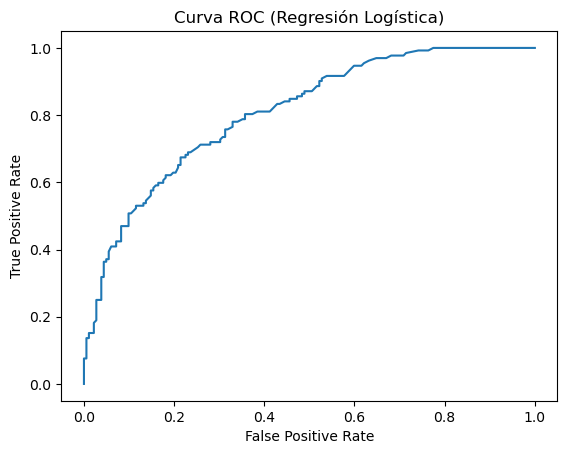

AUC: 0.8073801198801198


In [31]:
y_prob = log_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

plt.figure()
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC (Regresión Logística)")
plt.show()

print("AUC:", roc_auc)

In [27]:
##El modelo logístico su fin es clasificar si una empresa se considera exitosa o no, lo que hace la diferencia .  

In [29]:
##Por el análisis de las variables seleccionadas, pueden localizarse ciertos factores de la empresa.La red bayesiana permite analizar probabilidades condicionales lo que facilita los distintos escenarios.  

In [30]:
##Aplicamos 3 enfoques distintos, todos aportan distintas cosas pero todas se complementan entre si, la red bayesiana da la estratégia.